## Importing the libraries

In [204]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#inline matplotlib

## Importing the data 

In [205]:
# Importing the data
energy = pd.read_csv("consumption_train.csv", index_col=0)
meta = pd.read_csv("meta.csv")

## Extracting the dimensions of each dataset

In [206]:
# Printing the column names and dimension of both data sets
print("The columns are =>", energy.columns)
print("The timeseries dataset dimensions are =>", energy.shape)
print("The metadata dataset dimensions are =>", meta.shape)

The columns are => Index(['series_id', 'timestamp', 'consumption', 'temperature'], dtype='object')
The timeseries dataset dimensions are => (509376, 4)
The metadata dataset dimensions are => (1383, 10)


In [221]:
# Preview of the datasets
print(energy.info())
print()
print(meta.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509376 entries, 0 to 509375
Data columns (total 4 columns):
series_id      509376 non-null int64
timestamp      509376 non-null object
consumption    509376 non-null float64
temperature    280687 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 19.4+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 10 columns):
series_id               1383 non-null int64
surface                 1383 non-null object
base_temperature        1383 non-null object
monday_is_day_off       1383 non-null bool
tuesday_is_day_off      1383 non-null bool
wednesday_is_day_off    1383 non-null bool
thursday_is_day_off     1383 non-null bool
friday_is_day_off       1383 non-null bool
saturday_is_day_off     1383 non-null bool
sunday_is_day_off       1383 non-null bool
dtypes: bool(7), int64(1), object(2)
memory usage: 41.9+ KB
None


## Counting the missing values

In [211]:
# Counting missing values
print(energy.isnull().sum())
print()
print(meta.isnull().sum())

series_id           0
timestamp           0
consumption         0
temperature    228689
dtype: int64

series_id               0
surface                 0
base_temperature        0
monday_is_day_off       0
tuesday_is_day_off      0
wednesday_is_day_off    0
thursday_is_day_off     0
friday_is_day_off       0
saturday_is_day_off     0
sunday_is_day_off       0
dtype: int64


## Exploratory Data Analysis
### Correlation between energy consumption and temperature

,series_id,consumption,temperature
series_id,1.000000,0.013681,-0.116543
consumption,0.013681,1.000000,0.099456
temperature,-0.116543,0.099456,1.000000


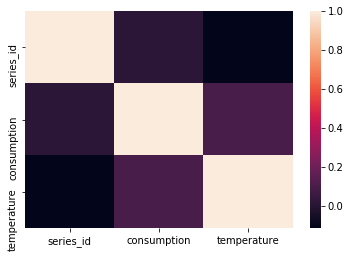

In [213]:
# Getting correlational heatmap, focussing on the potential relationship between consumption and temperature
corr = energy.corr()
sns.heatmap(corr, 
          xticklabels=corr.columns.values,
          yticklabels=corr.columns.values)
corr

In [80]:
new_col = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
cols = ["monday_is_day_off", "tuesday_is_day_off", "wednesday_is_day_off", "thursday_is_day_off",
       "friday_is_day_off", "saturday_is_day_off", "sunday_is_day_off"]

def add_empty_col(df, col):
    df[col] = 0

def convert_bool_binary(df, col, new_col):
    for i in range(len(df)):
        if df[col][i] == False:
            df[new_col][i] = 0
        else:
            df[new_col][i] = 1
            
#Looking for potential grouping patterns in days of the week ON/OFF
print("Different levels of the surface feature:",meta.surface.unique())
print("Different levels of the base_temperature feature:", meta.base_temperature.unique())

# Adding new empty columns (see above [new_col]) to fill them in with binary variable
# on whether it is a day OFF/ON
for i in new_col:
    add_empty_col(meta, i)
    


# This is highly inefficient!!! See if we can vectorized the above function 
convert_bool_binary(meta, "monday_is_day_off", "monday")
convert_bool_binary(meta, "tuesday_is_day_off", "tuesday")
convert_bool_binary(meta, "wednesday_is_day_off", "wednesday")
convert_bool_binary(meta, "thursday_is_day_off", "thursday")
convert_bool_binary(meta, "friday_is_day_off", "friday")
convert_bool_binary(meta, "saturday_is_day_off", "saturday")
convert_bool_binary(meta, "sunday_is_day_off", "sunday")

# Creating a new descriptive feature where a vector is created representing if power is shut down (i.e., 1) 
# or turn on (i.e., 0). This will help grouping similar buildings together 
meta["weekly"] = meta.monday.map(str) + meta.tuesday.map(str) + meta.wednesday.map(str) + meta.thursday.map(str) + meta.friday.map(str) + met

Different levels of the surface feature: ['x-large' 'x-small' 'medium' 'large' 'xx-large' 'xx-small' 'small']
Different levels of the base_temperature feature: ['low' 'high']


## EDA 2 - Looking At The Count Of Each Weekly Group

In [215]:
# Number of buildings in each weekly group
sns.countplot(x="weekly", data=meta)

ValueError: Could not interpret input 'weekly'

Looking at the last table, we get some more insights on power utilization. We can observe a higher number
buildings (e.g., 1236) having the power turned on. Now, it would be interesting to look if these patterns correlate with the spikes observed in the timeseries. If so, we can think of creating 7 different models, each locked to a specific power usage.  
    
 N.B.: The notation on the x-axis is quite confusing. Here is the legend associated with it:
     - 0000000 => Mon-Tues-Wed-Thu-Fri-Sat-Sun :  104
    -  0000001 => Mon-Tues-Wed-Thu-Fri-Sat     :   21
    -  0000010 => Mon-Tues-Wed-Thu-Fri-Sun     :    5
    -  0000011 => Mon-Tues-Wed-Thu-Fri         : 1236
    -  0000111 => Mon-Tues-Wed-Thu             :   10
    -  0011111 => Mon-Tues                     :    3
    -  1111111 => No days on                   :    4

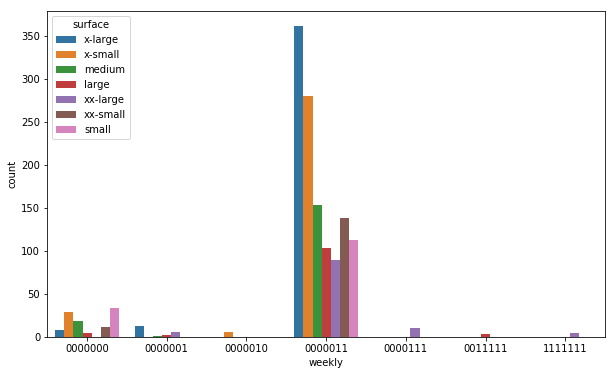

In [195]:
# Number of buildings for each weekly group deparated by their surface
plt.figure(figsize=(10,6))
sns.countplot(x="weekly", data=meta, hue="surface")